In [1]:
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Store Data Variables
import json
with open('feature_data.json', 'r') as f:
 features = json.load(f)

from scipy.io import loadmat
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()
query_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()
labels = loadmat('cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
gallery_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()
filelist = loadmat('cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
camId = loadmat('cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()

In [9]:

X = np.array(features)
y = np.array(labels)
filelist = np.array(filelist)
camId = np.array(camId)



In [10]:
mask_train = np.array(train_idxs).ravel()
mask_query = np.array(query_idxs).ravel()
mask_gallery = np.array(gallery_idxs).ravel()

mask_train = np.subtract(mask_train, 1)
mask_query = np.subtract(mask_query, 1)
mask_gallery = np.subtract(mask_gallery, 1)


X_train, X_query, X_gallery = X[mask_train, :], X[mask_query, :], X[mask_gallery, :]
y_train, y_query, y_gallery = y[mask_train], y[mask_query], y[mask_gallery]
filelist_train, filelist_query, filelist_gallery = filelist[mask_train], filelist[mask_query], filelist[mask_gallery]
camId_train, camId_query, camId_gallery = camId[mask_train], camId[mask_query], camId[mask_gallery]


In [72]:
def get_acc_score(y_valid, y_q, tot_label_occur):
    recall = 0
    true_positives = 0
    
    k = 0
    
    max_rank = 30
    
    rank_A = np.zeros(max_rank)
    AP_arr = np.zeros(11)
    
    while ((recall < 1) or (k < max_rank)) and (k < y_valid.shape[0]):
        
        if (y_valid[k] == y_q):
            
            true_positives = true_positives + 1
            recall = true_positives/tot_label_occur
            precision = true_positives/(k+1)
            
            AP_arr[round((recall-0.05)*10)] = precision
            
            for n in range (k, max_rank):
                rank_A[n] = 1
            
        k = k+1
        
    max_precision = 0
    for i in range(10, -1, -1):
        max_precision = max(max_precision, AP_arr[i])
        AP_arr[i] = max_precision
    
    AP_ = AP_arr.sum()/11
    
    return AP_, rank_A

In [122]:
from scipy.spatial import distance
from sklearn.metrics import pairwise


def evaluate_metric_rerank(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, metric = 'euclidian', parameters = None):

    rank_accuracies = []
    AP = []
    
    max_rank = parameters

    # Break condition for testing
    #q = 0

    for query, camId_q, y_q in zip(X_query, camId_query, y_query):
        q_g_dists = []
        y_valid = []
        X_valid = []
        for gallery, camId_g, y_g  in zip(X_gallery, camId_gallery, y_gallery):
            if ((camId_q == camId_g) and (y_q == y_g)):
                continue
            else:
                if metric == 'sqeuclidean':
                    dist = distance.sqeuclidean(query, gallery)
                else:
                    raise NameError('Specified metric not supported')           
                q_g_dists.append(dist)
                y_valid.append(y_g)
                X_valid.append(gallery)
    
        
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
        X_valid = np.array(X_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid, X_valid = q_g_dists[_indexes], y_valid[_indexes], X_valid[_indexes]
        
        print ('\n')
        print ('Looking for: ', y_q)
        print ('Initial:\t', y_valid[0:10])
        
            
        
        
        final_ranklist_labels = []

        for gal1, dist_, y in zip(X_valid[0:max_rank-1], q_g_dists[0:max_rank-1], y_valid[0:max_rank-1]):
            reciprocal_dists = []
            for gal2 in X_valid[0:max_rank+150]:
                if (np.array_equal(gal1, gal2)):
                    continue
                else:
                    dist = distance.sqeuclidean(gal1, gal2)
                    reciprocal_dists.append(dist)
            reciprocal_dists = np.array(reciprocal_dists)
            _indexes = np.argsort(reciprocal_dists)
            reciprocal_dists = reciprocal_dists[_indexes]
            if dist_ < reciprocal_dists[max_rank-1]:
                final_ranklist_labels.append(y)
        
        
        tot_label_occur = final_ranklist_labels.count(y_q)
        
        final_ranklist_labels = np.array(final_ranklist_labels)
        
                
        print('After:\t\t', final_ranklist_labels[0:10])    
            
        AP_, rank_A = get_acc_score(final_ranklist_labels, y_q, tot_label_occur)
    
        AP.append(AP_)
        
        rank_accuracies.append(rank_A)
    
        #if q  > 5:
        #    break
        #q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [123]:
rank_accuracies_l = []
mAP_l = []
metric_l = []

In [128]:
k_rn = 10

# Re-Ranking
rank_accuracies, mAP = evaluate_metric_rerank(X_query, camId_query, y_query,
                                              X_gallery, camId_gallery, y_gallery,
                                              metric ='sqeuclidean',
                                              parameters = k_rn)

rank_accuracies_l.append(rank_accuracies)
mAP_l.append(mAP)
metric_l.append('ReRank')




Looking for:  3
Initial:	 [1368  739 1426   51 1368   14   14 1450   51 1368]
After:		 [1426 1368   14   14]


Looking for:  3
Initial:	 [ 517  235  235 1426  725   86   51 1426  172    3]
After:		 [ 517  235   86 1426  172]


Looking for:  6
Initial:	 [  6   6   6   6 678  77  77 678 678 648]
After:		 [  6   6   6   6 678  77 678]


Looking for:  6
Initial:	 [  6   6   6   6 678 678 678 678 678  72]
After:		 [  6   6   6   6 678]


Looking for:  7
Initial:	 [ 22   7 382  22   7 303   7 854   7 441]
After:		 [ 22   7 382  22   7   7   7]


Looking for:  7
Initial:	 [319 319   7 319   7   7   7 319  22  22]
After:		 [7 7 7 7]


Looking for:  11
Initial:	 [390 738  11 738  11  55  11 625 211  42]
After:		 [390  11 625]


Looking for:  11
Initial:	 [738  55 721  11 721 721 401 721 738 763]
After:		 [ 55  11 721 721]


Looking for:  14
Initial:	 [ 14  14   3  51  14  51  51 182 650  51]
After:		 [14 14 51 14]


Looking for:  14
Initial:	 [ 14  14  14  14 739 291  51 182 182 739]
After:		



Looking for:  96
Initial:	 [400 400  96  96  96 325 351  96 488 899]
After:		 [400 400  96  96  96 325  96 488]


Looking for:  96
Initial:	 [ 96 194 487 824 351  96 325 194 519 351]
After:		 [ 96 194 487 824  96 194 519]


Looking for:  98
Initial:	 [635 239 239 239 635 235 254 635 239 254]
After:		 [635 239 239 239 635 235 635]


Looking for:  98
Initial:	 [239 239 635 239 239 254  98  98 254 445]
After:		 [239 239 635 239 239 254]


Looking for:  99
Initial:	 [235 235 556  99 445 556 239 556  99 556]
After:		 [99 99]


Looking for:  99
Initial:	 [120 105 120 739 186 254 103 366 120  99]
After:		 [120 105 120 186 103]


Looking for:  100
Initial:	 [742 427 722 491 722 491 742 156 136 111]
After:		 [742 427]


Looking for:  100
Initial:	 [241 100 399 721 738 399 649 294 471 384]
After:		 [241 100 399 649 471]


Looking for:  101
Initial:	 [101 101 101 101  74  74 212  74 212 159]
After:		 [101 101 101 101  74]


Looking for:  101
Initial:	 [101 101  74 101 101  74 326  74 212  74]
A



Looking for:  162
Initial:	 [ 162  162  361  464  162  162 1028 1028  464  464]
After:		 [ 162  162  464  162 1028]


Looking for:  163
Initial:	 [163 373 504 390 749 783 749 241 294 504]
After:		 [163 373 390 749 783 241 294]


Looking for:  163
Initial:	 [349 148 504 128 349 232 643 129 349 349]
After:		 [349 148 504 128 643]


Looking for:  164
Initial:	 [349 232 232 424  42 666 216 232 548 548]
After:		 [349 232 232 424 232 548]


Looking for:  164
Initial:	 [ 360  360  423  129  423  360  423  424  423 1179]
After:		 [360 360 129 360]


Looking for:  165
Initial:	 [135 135 135 135 789 789 789 165 789 834]
After:		 [135 135 135 135 165]


Looking for:  165
Initial:	 [135 374 220 367 763 367 165 165 536 382]
After:		 [135 374 220 367 367 165 165 536]


Looking for:  166
Initial:	 [ 190  254  635 1369  635  254  254   35 1369  235]
After:		 [ 190 1369]


Looking for:  166
Initial:	 [254 254 522 440 726 440 440 726 254 726]
After:		 [254 522 440 440 440]


Looking for:  170
Initial:



Looking for:  230
Initial:	 [331 331 331 340 340 331 340 340 331 319]
After:		 [331 331 340 340 331]


Looking for:  230
Initial:	 [ 625  593 1353  625  625  643  230  333  625  128]
After:		 [ 625  593 1353  625  230]


Looking for:  232
Initial:	 [691 232 232 691 369 691 349 691  74 666]
After:		 [691 232 232 691 369 349]


Looking for:  232
Initial:	 [544 544 544 148 228 164 349 623 310 228]
After:		 [544 544 164 349]


Looking for:  235
Initial:	 [235 235 235 635 635 635 635 172 254 235]
After:		 [235 235 235 172]


Looking for:  235
Initial:	 [239 239 239 239  98  98 254 635 678 239]
After:		 [239 239 239 239 678]


Looking for:  236
Initial:	 [475 441 475 441 542 475 250 236 475 542]
After:		 [542]


Looking for:  236
Initial:	 [236  41 250 250 250 250 236 250 250 250]
After:		 [236  41 250 236]


Looking for:  237
Initial:	 [237 237 331 237 331 331 780 340 237 331]
After:		 [237 237 331 237 331 780 237]


Looking for:  237
Initial:	 [ 237 1407  237  237 1407  237 1407  786  30



Looking for:  316
Initial:	 [ 304  317  304  902  304  902  691  170 1376  691]
After:		 [304 317 304 902 304 691]


Looking for:  316
Initial:	 [316 763 401 316 763 401 258 316 247 292]
After:		 [316 763 401 316 763 258 316]


Looking for:  317
Initial:	 [374 448 448 374 220 448 374 317 374 652]
After:		 [374 448 448 374 317]


Looking for:  317
Initial:	 [ 317  317  652 1407  652  317  448  593  575  647]
After:		 [ 317  317  652 1407  652  317  448  593  575]


Looking for:  319
Initial:	 [ 319  319 1451  319 1451  319  426   22  303   22]
After:		 [ 319  319 1451  319 1451  319  426]


Looking for:  319
Initial:	 [ 319  319  303  319  319 1273  303  303  303  303]
After:		 [ 319  319  319 1273]


Looking for:  320
Initial:	 [694 694 694 320 320 599 694 694 599 599]
After:		 [694 694 694 320 599 694 694]


Looking for:  320
Initial:	 [ 320  320  569  660 1300  694  660 1300  694  569]
After:		 [ 320  320  569 1300  694 1300  694]


Looking for:  321
Initial:	 [321 321 321 321 826 



Looking for:  381
Initial:	 [238 238 238 238 238 499 238 238 499 381]
After:		 [238 238 238 238 238 499 238 238 499]


Looking for:  381
Initial:	 [ 381  346  381  381  346  559 1312  381  346   76]
After:		 [381 346 381 381 346 559 381 346]


Looking for:  382
Initial:	 [521 367 521 367 521 401 367 367 763 374]
After:		 [521 367 521 367 521 367 763]


Looking for:  382
Initial:	 [367 367 763 471 521 367 471 471 521 374]
After:		 [367 367 763 471 471 471]


Looking for:  384
Initial:	 [384 384 401 401 367 401 459 384 769 459]
After:		 [384 384 459]


Looking for:  384
Initial:	 [384 384 384 400 401 401 463 401 382 135]
After:		 [384 384 384 400 463]


Looking for:  388
Initial:	 [394 378 378 402 388 429 388 394 556 378]
After:		 [394 402 388 388]


Looking for:  388
Initial:	 [388 479 479 388 378 479 573 112 112 479]
After:		 [388 479 479 573]


Looking for:  390
Initial:	 [699 652 699 699 699 699 699 699 692 692]
After:		 [699 652 699 699 699 699 699 699 692]


Looking for:  390
Ini



Looking for:  457
Initial:	 [457 457 457 457 772 772 772 772 715  91]
After:		 [457 457 457 457]


Looking for:  459
Initial:	 [ 367  459  459  367  367  367  459  367 1372  376]
After:		 [367 459 459]


Looking for:  459
Initial:	 [519 487 487 519 519 425 459 367 471 471]
After:		 [519 487 519 519 425 459 471]


Looking for:  460
Initial:	 [557 555 217 555 566 460 555 557 217 555]
After:		 [460]


Looking for:  460
Initial:	 [157 463 463 157  28 157 424 361 463  28]
After:		 [157 463 463 157 424]


Looking for:  461
Initial:	 [461 461 590 590 461 590 461 422 590 422]
After:		 [461 461 590 590 461 590 461 590]


Looking for:  461
Initial:	 [461 461 461 461 590 360 590 590 475 590]
After:		 [461 461 461 461 590 360 590]


Looking for:  463
Initial:	 [463 463  28 361 157 384 463 463 157 725]
After:		 [463 463  28 361 463 463 157]


Looking for:  463
Initial:	 [384 422 422 384 422 384 384 442 423 361]
After:		 [384 422 422 384 422 384 442]


Looking for:  464
Initial:	 [494 494 464 429 

After:		 [586 586 586 291 291]


Looking for:  542
Initial:	 [ 42 423  42 423  42 423  42 566 566 566]
After:		 [ 42 423 423  42 423 566]


Looking for:  544
Initial:	 [148 148 625 751 148 147 691 744 625 304]
After:		 [148 148 625 751 148 147 691 625]


Looking for:  544
Initial:	 [148 147 310 148 623 232 147 672 147 669]
After:		 [148 147 310 148 623 232 147 672 147]


Looking for:  545
Initial:	 [ 699  699  699  888  294 1199  558  131 1225  163]
After:		 [ 699 1199]


Looking for:  545
Initial:	 [131 738 763 763 584 448 640 584 640 640]
After:		 [131 763 763 584 448 640 584 640]


Looking for:  547
Initial:	 [547 547 547 418 337 437 372 437 418 372]
After:		 [547 547 547 418 437 372 437 418]


Looking for:  547
Initial:	 [547 547 337 337 337 337 547 547 849 337]
After:		 [547 547 337 337 337 337 547 547]


Looking for:  548
Initial:	 [557 349 564 216 557 216 564 349 442 442]
After:		 [557 349 216 216 564 349]


Looking for:  548
Initial:	 [372 372 694 499 372 320 372 372 640 694]
A



Looking for:  638
Initial:	 [725 725 725 769 754 725 145 754 592 638]
After:		 [725 725 725 769 754 725]


Looking for:  640
Initial:	 [409 409 326 390 409 437  41 437 409 418]
After:		 [409 409 326 390 409 409]


Looking for:  640
Initial:	 [672 652 763 448 220 374 448 652 448 584]
After:		 [672 652]


Looking for:  643
Initial:	 [310 148 148 148 148 232 228 706 706 164]
After:		 [310 148 148 232 706 706]


Looking for:  643
Initial:	 [623 623 623 623 623  74 623 744 623  74]
After:		 [623 623 623 623 623 623 623]


Looking for:  645
Initial:	 [645 645 645 645 537 544 537 236 703 537]
After:		 [645 645 645 645 537 544 537 236]


Looking for:  645
Initial:	 [645 645 645 645 537 537 544 475 475 537]
After:		 [645 645 645 645 537 537 544]


Looking for:  646
Initial:	 [646 646 586 646 646 586 841 586 296 258]
After:		 [646 646 586 646 646 586 841]


Looking for:  646
Initial:	 [ 646  646  646  646  672 1369  120  692  120  258]
After:		 [ 646  646  646  646  672 1369  120]


Looking fo



Looking for:  706
Initial:	 [706 706 706 706 310 310 440 232 310 310]
After:		 [706 706 706 706]


Looking for:  708
Initial:	 [708 904 757 696 757 708 866 757 708 708]
After:		 [708 904 757 696 708 866 708]


Looking for:  708
Initial:	 [757 757 757 708 708 708 757 708 757 757]
After:		 [757 757 757 708 708 708 757 708 757]


Looking for:  710
Initial:	 [710 710 710 710  72  72 266 398 145 758]
After:		 [710 710 710 710]


Looking for:  710
Initial:	 [ 710  710  710  710   72   72   72  931   72 1434]
After:		 [710 710 710 710  72  72  72 931  72]


Looking for:  715
Initial:	 [715 715 715 715 115 115  17  17 872  17]
After:		 [715 715 715 715 115 115  17  17]


Looking for:  715
Initial:	 [715 715 715 715 115 872 872 872 872 115]
After:		 [715 715 715 715 115 872 872 872 872]


Looking for:  716
Initial:	 [754 754 306 752 280 280 898 691 409 440]
After:		 [754 752 280 280 898]


Looking for:  716
Initial:	 [597 196 326 326 196 597 326 196  81 597]
After:		 [597]


Looking for:  717



Looking for:  770
Initial:	 [770 112 770 479 518 112 131 770 112 824]
After:		 [770 112 770 479 518 112 131 770 112]


Looking for:  772
Initial:	 [115 715 715 715 715 715 715 715 223 115]
After:		 [115 715 715]


Looking for:  772
Initial:	 [772 772 772  32 772 223  32 537  32 223]
After:		 [772 772 772  32 537  32]


Looking for:  773
Initial:	 [375 375  89 375 762  89  80  80  80  89]
After:		 [375  89]


Looking for:  773
Initial:	 [ 301  301  301  301  773  488  488  488 1376  474]
After:		 [301 301 301 301]


Looking for:  780
Initial:	 [780 780 159 159 159 159 780 780 340 331]
After:		 [780 780 159 159 159 159 780 780]


Looking for:  780
Initial:	 [780 780 159 159 780 159 780  22 159  22]
After:		 [780 780 159 159 780 159 780 159]


Looking for:  783
Initial:	 [1313  691  228  752  752  744  623  333  744  623]
After:		 [1313  752]


Looking for:  783
Initial:	 [1353  228  271  271  333  333  228  757 1353  258]
After:		 [1353]


Looking for:  784
Initial:	 [784 784 784 784 7



Looking for:  843
Initial:	 [ 843  843   96 1225  149 1213   96  938 1307 1213]
After:		 [ 843  843 1307]


Looking for:  846
Initial:	 [ 892  902 1376  902  902  892  899  883 1331  880]
After:		 [ 892 1376  883 1331]


Looking for:  846
Initial:	 [ 862 1376 1376  846 1376 1042  862 1376  862  846]
After:		 [ 862 1376  846 1042  862  862]


Looking for:  849
Initial:	 [ 849  849  849  849 1022 1354 1062 1062 1022 1062]
After:		 [ 849  849  849  849 1354]


Looking for:  849
Initial:	 [ 849 1022  804 1062 1022 1350 1062 1062 1062  849]
After:		 [ 849  804 1350]


Looking for:  851
Initial:	 [ 849  998  223 1132  872 1354 1132  849  907  849]
After:		 [ 849  998 1132  872 1354  849  907]


Looking for:  851
Initial:	 [ 879  756  851 1336 1330 1360 1360  879 1336 1330]
After:		 [ 851 1360  879]


Looking for:  853
Initial:	 [ 886  899  877  929  869 1030  886  877  886  892]
After:		 [886 899 877 929 869 886 877 886]


Looking for:  853
Initial:	 [ 886  886  886  853  902  886 1064 140



Looking for:  902
Initial:	 [ 236  236 1047  645  645 1047 1047 1159 1047  236]
After:		 [1159]


Looking for:  903
Initial:	 [903 903 903 903 450 450 888 450 893 880]
After:		 [903 903 903 903 450]


Looking for:  903
Initial:	 [903 903 903 903 888 655 932 450 450 450]
After:		 [903 903 903 903 932]


Looking for:  904
Initial:	 [903 903 869 854 903 880 873 903 988 873]
After:		 [903 903 903]


Looking for:  904
Initial:	 [  45 1273 1273   45 1107 1114 1159   45 1159 1107]
After:		 [45]


Looking for:  905
Initial:	 [ 816   40   62  320   40 1384 1435  332   40   62]
After:		 [ 816   40   62  320   40 1384 1435  332   40]


Looking for:  905
Initial:	 [ 905  905  905 1342 1140 1233 1065  870 1359 1116]
After:		 [ 905  905  905 1342 1140 1233 1065]


Looking for:  907
Initial:	 [862 863 862 863 863 862 862 980 862 980]
After:		 [862 863 862 863 863 862 862]


Looking for:  907
Initial:	 [1367 1367  294  294  863 1367  862 1367 1367 1128]
After:		 [1367 1367  294  294 1367]


Looking 



Looking for:  967
Initial:	 [1257 1155 1127  902  965 1037 1037 1127 1155  967]
After:		 [1257 1155 1127  902  965 1127]


Looking for:  968
Initial:	 [1179 1179 1179 1179  968 1179  968  909  933 1179]
After:		 [1179 1179 1179 1179  968 1179  968  909]


Looking for:  968
Initial:	 [ 989  968  932  989  933  933  932 1075  989  932]
After:		 [989 968 989 989]


Looking for:  969
Initial:	 [1162 1162  979 1162  946  980 1271  946 1162 1241]
After:		 [1162 1162  979 1162  946  980 1271  946 1162]


Looking for:  969
Initial:	 [1389 1389 1406  979  969 1007  969  979  925 1007]
After:		 [1389 1389 1406  979 1007  969  979  925]


Looking for:  970
Initial:	 [1122 1063 1063 1068  999 1121  971 1063 1063  988]
After:		 [1122 1063 1063 1068 1121  971 1063 1063]


Looking for:  970
Initial:	 [1064  971 1148  970 1148 1407 1064 1148 1068 1026]
After:		 [1064  971 1148  970 1148 1407 1064 1068]


Looking for:  971
Initial:	 [ 922  971 1026  758 1068 1148  758  796  971  971]
After:		 [ 922 1



Looking for:  1041
Initial:	 [1041 1041 1041 1041 1054  947  947 1375  947  947]
After:		 [1041 1041 1041 1041 1054  947 1375  947]


Looking for:  1042
Initial:	 [ 999  999 1028 1042  999 1028 1028 1037  999 1068]
After:		 [ 999  999 1028 1042  999 1028 1028]


Looking for:  1042
Initial:	 [1042 1042 1042  982 1376  982  463  965 1042 1047]
After:		 [1042 1042 1042  982 1376]


Looking for:  1043
Initial:	 [1221 1221 1221 1221 1009 1221 1009 1142 1009 1009]
After:		 [1221 1221 1221 1221 1009 1142]


Looking for:  1043
Initial:	 [1043  991  991 1221  991  883 1221 1221  991 1221]
After:		 [1043  991  991 1221  991  883 1221  991]


Looking for:  1044
Initial:	 [1044 1044 1044 1044 1107 1107 1148 1054 1042  989]
After:		 [1044 1044 1044 1044 1107 1054]


Looking for:  1044
Initial:	 [1044 1044 1044  180 1044  180  180  396  180  396]
After:		 [1044 1044 1044 1044]


Looking for:  1047
Initial:	 [1047 1047 1047 1232 1232 1052 1132  902 1232 1232]
After:		 [1047 1047 1047 1232 1232 1132



Looking for:  1117
Initial:	 [1117 1241  950 1241 1007  950 1216  950 1117 1117]
After:		 [1117 1241  950 1241 1007  950 1216  950 1117]


Looking for:  1117
Initial:	 [1004 1117 1069 1217 1117  429  933  429 1174 1217]
After:		 [1004 1117 1069]


Looking for:  1121
Initial:	 [1121 1121 1128 1128  934  893 1133  934  988  938]
After:		 [1121 1121 1128  893  934  988]


Looking for:  1121
Initial:	 [1121 1121 1121  970  938 1121  988  938  988 1091]
After:		 [1121 1121 1121  970  938 1121  988  988]


Looking for:  1122
Initial:	 [1068 1111 1111 1026  922 1111  922 1068  145 1026]
After:		 [1068 1111 1111 1026 1111  145]


Looking for:  1122
Initial:	 [1122 1122 1375 1375 1375 1122 1375  938 1265  967]
After:		 [1122 1122 1122  938]


Looking for:  1123
Initial:	 [1259  998 1259  980  998 1220 1011 1037 1259  925]
After:		 [1259  998  980 1220 1037]


Looking for:  1123
Initial:	 [1063 1063  980 1221 1259 1037  998 1009 1011 1063]
After:		 [1063 1063  980 1221 1259 1037  998]


Lookin



Looking for:  1193
Initial:	 [1193 1193 1193 1193  884  939 1225  884 1225 1225]
After:		 [1193 1193 1193 1193  939 1225 1225]


Looking for:  1193
Initial:	 [ 884  884 1193  884 1193 1193 1193  884  884 1227]
After:		 [ 884  884 1193  884 1193 1193 1193  884  884]


Looking for:  1195
Initial:	 [ 946  925 1155 1221  925 1162 1075 1189 1123 1221]
After:		 [ 946  925 1155  925 1162 1075 1189 1123]


Looking for:  1195
Initial:	 [1037  968 1257  968 1217 1217  930 1037  916 1217]
After:		 [1037  968 1257  968  930]


Looking for:  1197
Initial:	 [1197  929 1224 1224  929 1276  929 1190 1127  929]
After:		 [1197  929 1224 1224  929]


Looking for:  1197
Initial:	 [1002  881 1002 1013  881  881  881  881  881 1145]
After:		 [1002  881 1002  881  881  881]


Looking for:  1199
Initial:	 [1098 1063 1099 1098  970 1147  999 1098 1182 1098]
After:		 [1098 1063 1099 1098 1098]


Looking for:  1199
Initial:	 [1199 1063 1182 1182 1199 1199 1182  863 1182  655]
After:		 [1199]


Looking for:  12



Looking for:  1264
Initial:	 [1017 1178 1017 1178 1017  968 1017 1204 1097 1096]
After:		 [1017 1178 1017 1178  968]


Looking for:  1264
Initial:	 [1096 1264 1264 1096 1011 1075 1096 1096 1004 1075]
After:		 [1264 1264 1011]


Looking for:  1265
Initial:	 [1265 1265  939 1265  939 1265  474  301  474 1170]
After:		 [1265 1265 1265]


Looking for:  1265
Initial:	 [1265 1265 1265 1265 1170 1170  474  474  939  474]
After:		 [1265 1265 1265 1265]


Looking for:  1266
Initial:	 [1131 1131 1263 1266 1133 1134 1134 1133 1131 1133]
After:		 [1131 1131 1263 1266 1133 1134 1134 1133 1131]


Looking for:  1266
Initial:	 [1273 1266 1195 1265 1140 1273  989 1193 1251  869]
After:		 [1273 1195 1265 1251]


Looking for:  1270
Initial:	 [1242 1242 1270 1145 1270 1270 1257  967  902 1209]
After:		 [1242 1242 1270 1270 1270 1257  967  902]


Looking for:  1270
Initial:	 [1270 1270 1188 1032 1242 1188 1078 1032 1242 1270]
After:		 [1270 1270 1078]


Looking for:  1271
Initial:	 [1216 1162 1112 1162 1



Looking for:  1365
Initial:	 [1365  870 1365  870  870  870 1365  218  218  218]
After:		 [1365  870 1365  870  870  870 1365  218  218]


Looking for:  1365
Initial:	 [1365 1365 1365  902 1365  902  870  336  870  870]
After:		 [1365 1365 1365  902 1365  902  336]


Looking for:  1367
Initial:	 [ 907  907  907 1111  926  926 1367 1010 1111  822]
After:		 [ 907  907  907 1111 1367 1111]


Looking for:  1367
Initial:	 [1367 1367 1367 1367  822  822 1372  401  863  846]
After:		 [1367 1367 1367 1367  822  822]


Looking for:  1368
Initial:	 [1368 1368    3  739 1368  739    3    3 1387 1368]
After:		 [1368 1368    3  739 1368  739    3    3]


Looking for:  1368
Initial:	 [1368 1368 1368 1426 1387 1368 1387 1387  882 1387]
After:		 [1368 1368 1368 1426 1387 1368  882]


Looking for:  1369
Initial:	 [1406 1392 1406  841 1406  166  841  254 1371  166]
After:		 [1406 1392 1406  841 1406  166  841 1371]


Looking for:  1369
Initial:	 [ 871 1223  871  871  946 1223  883 1095 1223 1406]
Afte

After:		 [1438 1438 1438]


Looking for:  1440
Initial:	 [1443 1457 1426 1443 1271 1426 1457 1422 1426 1443]
After:		 [1443 1457 1443 1271 1426 1457 1422]


Looking for:  1440
Initial:	 [1384  267 1435 1384  267  970  145 1026 1435  171]
After:		 [1384 1435 1384  267  970  145 1435]


Looking for:  1443
Initial:	 [1389 1389 1457 1389  933 1075 1457 1389  932 1385]
After:		 [1389 1389 1457 1389 1389]


Looking for:  1443
Initial:	 [1389 1389 1443 1285 1443 1389  841 1440   86  717]
After:		 [1389 1389  841]


Looking for:  1445
Initial:	 [1387 1426 1387 1387 1368 1387 1368 1450 1368 1426]
After:		 [1387 1426 1387 1387 1387 1368 1450 1368]


Looking for:  1445
Initial:	 [1002 1002 1002 1307 1091  870 1365  859  870  870]
After:		 [1002 1002 1002 1307  870]


Looking for:  1449
Initial:	 [1398 1398 1398 1397 1398 1326 1398 1450 1440 1326]
After:		 [1398 1398 1398 1397 1398 1326 1440]


Looking for:  1449
Initial:	 [1440  267 1461 1440 1398 1398 1449 1398  242 1449]
After:		 [1440  267 144

In [ ]:
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold', 'lightgreen']
for i in range(len(metric_l)):
    plt.plot(np.arange(1, 31), 100*rank_accuracies_l[i], color=color_list[i], linestyle='dashed', label='k : '+str(metric_l[i]))

plt.title('CMC Curves for a range of standard distance metrics')
plt.xlabel('Rank')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')

In [228]:
from scipy.spatial import distance
from sklearn.metrics import pairwise
from sklearn.neighbors import NearestNeighbors


def evaluate_metric_rerank_improved(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, metric = 'euclidian', parameters = None):

    rank_accuracies = []
    AP = []
    
    max_rank = parameters

    # Break condition for testing
    q = 0

    for query, camId_q, y_q in zip(X_query, camId_query, y_query):
        q_g_dists = []
        y_valid = []
        X_valid = []
        for gallery, camId_g, y_g  in zip(X_gallery, camId_gallery, y_gallery):
            if ((camId_q == camId_g) and (y_q == y_g)):
                continue
            else:
                if metric == 'sqeuclidean':
                    dist = distance.sqeuclidean(query, gallery)
                else:
                    raise NameError('Specified metric not supported')           
                q_g_dists.append(dist)
                y_valid.append(y_g)
                X_valid.append(gallery)
    
        
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
        X_valid = np.array(X_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid, X_valid = q_g_dists[_indexes], y_valid[_indexes], X_valid[_indexes]
        
        #print ('\n')
        #print ('Looking for: ', y_q)
        #print ('Initial:\t', y_valid[0:10])
        

        initial_ranklist_labels = []
        initial_ranklist_elements = []

        for gal1, dist_, y in zip(X_valid[0:max_rank-1], q_g_dists[0:max_rank-1], y_valid[0:max_rank-1]):
            reciprocal_dists = []
            for gal2 in X_valid[0:max_rank+150]:
                if (np.array_equal(gal1, gal2)):
                    continue
                else:
                    dist = distance.sqeuclidean(gal1, gal2)
                    reciprocal_dists.append(dist)
            reciprocal_dists = np.array(reciprocal_dists)
            _indexes = np.argsort(reciprocal_dists)
            reciprocal_dists = reciprocal_dists[_indexes]
            if dist_ < reciprocal_dists[max_rank-1]:
                initial_ranklist_labels.append(y)
                initial_ranklist_elements.append(gal1)
        
        
        initial_ranklist_labels = np.array(initial_ranklist_labels)
        initial_ranklist_elements = np.array(initial_ranklist_elements)
        
        
        initial_ranklist_labels = list(initial_ranklist_labels)
        
        print (initial_ranklist_labels)
        
        if (len(initial_ranklist_labels) != 0):
        
            nn = NearestNeighbors(n_neighbors = int(max_rank/2)+1)
            nn.fit(X_valid[0:max_rank+150])
            dist, indices = nn.kneighbors(initial_ranklist_elements, n_neighbors = int(max_rank/2)+1)



            for indices_subset in indices:
                for index in indices_subset[1:int(max_rank/2)+1]:
                    included = False
                    for x in initial_ranklist_elements:
                        if(np.array_equal(x, X_valid[index])):
                            included = True
                    if included == False:
                        initial_ranklist_elements = np.concatenate((initial_ranklist_elements, X_valid[index].reshape((-1, X_valid[index].shape[0]))))
                        initial_ranklist_labels.append(y_valid[index])
        
        
        tot_label_occur = initial_ranklist_labels.count(y_q)
        
        initial_ranklist_labels = np.array(initial_ranklist_labels)
                
        #print('After:\t\t', initial_ranklist_labels[0:10])   
        
        
            
        AP_, rank_A = get_acc_score(initial_ranklist_labels, y_q, tot_label_occur)
    
        AP.append(AP_)
        
        rank_accuracies.append(rank_A)
    
        #if q  > 5:
        #    break
        print ('Done query ', q)
        q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [285]:
from scipy.spatial import distance
from sklearn.metrics import pairwise
from sklearn.neighbors import NearestNeighbors


def evaluate_metric_rerank_improved(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, metric = 'euclidian', parameters = None):

    rank_accuracies = []
    AP = []
    
    max_rank = parameters

    # Break condition for testing
    q = 0

    for query, camId_q, y_q in zip(X_query, camId_query, y_query):
        q_g_dists = []
        y_valid = []
        X_valid = []
        for gallery, camId_g, y_g  in zip(X_gallery, camId_gallery, y_gallery):
            if ((camId_q == camId_g) and (y_q == y_g)):
                continue
            else:
                if metric == 'sqeuclidean':
                    dist = distance.sqeuclidean(query, gallery)
                else:
                    raise NameError('Specified metric not supported')           
                q_g_dists.append(dist)
                y_valid.append(y_g)
                X_valid.append(gallery)
    
        
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
        X_valid = np.array(X_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid, X_valid = q_g_dists[_indexes], y_valid[_indexes], X_valid[_indexes]
        
        #print ('\n')
        #print ('Looking for: ', y_q)
        #print ('Initial:\t', y_valid[0:10])
        
        
        
        final_ranklist_labels = []
        final_ranklist_elements = []


        for gal1, dist_, y in zip(X_valid[0:max_rank-1], q_g_dists[0:max_rank-1], y_valid[0:max_rank-1]):
            reciprocal_dists = []
            for gal2 in X_valid[0:max_rank+150]:
                if (np.array_equal(gal1, gal2)):
                    continue
                else:
                    dist = distance.sqeuclidean(gal1, gal2)
                    reciprocal_dists.append(dist)
            reciprocal_dists = np.array(reciprocal_dists)
            _indexes = np.argsort(reciprocal_dists)
            reciprocal_dists = reciprocal_dists[_indexes]
            if dist_ < reciprocal_dists[max_rank-1]:
                final_ranklist_labels.append(y)
                final_ranklist_elements.append(gal1)
        
        
        final_ranklist_labels = np.array(final_ranklist_labels)
        final_ranklist_elements = np.array(final_ranklist_elements)
        

        initial_ranklist_labels = []
        initial_ranklist_elements = []
        
        
        
        nn = NearestNeighbors(n_neighbors = int(max_rank/2)+1)
        nn.fit(X_valid[0:max_rank+150])
        dist, indices = nn.kneighbors(X_valid[0:max_rank-1], n_neighbors = int(max_rank/2)+1)


        for indices_subset in indices:
            for index in indices_subset[1:int(max_rank/2)+1]:
                included = False
                for x in final_ranklist_elements:
                    if(np.array_equal(x, X_valid[index])):
                        included = True
                if included == False:
                    initial_ranklist_elements.append(X_valid[index])
                    initial_ranklist_labels.append(y_valid[index])
                        
                        
        
        initial_ranklist_labels = np.array(initial_ranklist_labels)
        initial_ranklist_elements = np.array(initial_ranklist_elements)
        
        if (final_ranklist_elements.shape[0] != 0) and (initial_ranklist_elements.shape[0] != 0):
            
            final_ranklist_labels = np.concatenate((final_ranklist_labels, initial_ranklist_labels))
            final_ranklist_elements = np.concatenate((final_ranklist_elements, initial_ranklist_elements))
        elif (initial_ranklist_elements.shape[0] != 0):
            final_ranklist_labels = initial_ranklist_labels
            final_ranklist_elements = initial_ranklist_elements
        
        
        
        
        tot_label_occur = list(final_ranklist_labels).count(y_q)
        
                
        #print('After:\t\t', final_ranklist_labels[0:10])   
        
        
            
        AP_, rank_A = get_acc_score(final_ranklist_labels, y_q, tot_label_occur)
    
        AP.append(AP_)
        
        rank_accuracies.append(rank_A)
    
        #if q  > 5:
        #    break
        print ('Done query ', q)
        q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [286]:
rank_accuracies_l = []
mAP_l = []
metric_l = []

In [287]:
k_rn = 5

# Re-Ranking
rank_accuracies, mAP = evaluate_metric_rerank_improved(X_query, camId_query, y_query,
                                                       X_gallery, camId_gallery, y_gallery,
                                                       metric ='sqeuclidean',
                                                       parameters = k_rn)

rank_accuracies_l.append(rank_accuracies)
mAP_l.append(mAP)
metric_l.append('ReRank')





Looking for:  3
Initial:	 [1368  739 1426   51 1368   14   14 1450   51 1368]
After:		 [1368 1368  739  726 1426 1426   51   51]
Done query  0


Looking for:  3
Initial:	 [ 517  235  235 1426  725   86   51 1426  172    3]
After:		 [ 517  517  235  235  235  235 1426 1426]
Done query  1


Looking for:  6
Initial:	 [  6   6   6   6 678  77  77 678 678 648]
After:		 [6 6 6 6]
Done query  2


Looking for:  6
Initial:	 [  6   6   6   6 678 678 678 678 678  72]
After:		 [6 6 6 6 6]
Done query  3


Looking for:  7
Initial:	 [ 22   7 382  22   7 303   7 854   7 441]
After:		 [  7 382  22 303   7   7 382 382  22 303]
Done query  4


Looking for:  7
Initial:	 [319 319   7 319   7   7   7 319  22  22]
After:		 [319 319 319 319   7   7 319 319]
Done query  5


Looking for:  11
Initial:	 [390 738  11 738  11  55  11 625 211  42]
After:		 [390 556 390 738 738  11  11 738 738]
Done query  6


Looking for:  11
Initial:	 [738  55 721  11 721 721 401 721 738 763]
After:		 [ 11 738 738  55  55 721 721



Looking for:  80
Initial:	 [ 80 435  80  80 435 435  89 435 435  80]
After:		 [ 80  80  80 435 435  80  80  80]
Done query  67


Looking for:  81
Initial:	 [196 597 196 326 597 223 196 326 223 326]
After:		 [196 196 196 597 597 196 326 326]
Done query  68


Looking for:  81
Initial:	 [666 666 548 170 691 666 691 232 333 148]
After:		 [ 548  170  666  666  666  666  548  756  170 1376]
Done query  69


Looking for:  86
Initial:	 [ 86  86  86  86 661 661 548 557 673 146]
After:		 [86 86 86 86]
Done query  70


Looking for:  86
Initial:	 [ 86  86  86 366 494 933 221 221 221 366]
After:		 [ 86  86  86  86 366 366]
Done query  71


Looking for:  89
Initial:	 [  89   89   89   89  773  488  435   80 1375  762]
After:		 [89 89 89 89]
Done query  72


Looking for:  89
Initial:	 [301 301  89  89  89  80 773 375 762 506]
After:		 [301 301 301 301  89  89  89  89]
Done query  73


Looking for:  91
Initial:	 [ 91  91  91  91 474 474 461 461 474 488]
After:		 [91 91 91 91]
Done query  74


Lookin



Looking for:  146
Initial:	 [673 673 673 673 649 649 661 649 673 649]
After:		 [673 673 673 673 673]
Done query  131


Looking for:  147
Initial:	 [505 163 317 647 349 672 652 157 157 652]
After:		 [505 505 505 163 163 317 317 647 647]
Done query  132


Looking for:  147
Initial:	 [129 544 157 129 133 163 151 544 147 151]
After:		 [129 544 129 157 544 544 157 157 129]
Done query  133


Looking for:  148
Initial:	 [544 147 148 643 148 148 643 792 148 792]
After:		 [544 148 643 544 544 147 147 148 148 643]
Done query  134


Looking for:  148
Initial:	 [228 349 643 643 129 129 129 157 643 147]
After:		 [228 228 228 216 216 643 643 643 643]
Done query  135


Looking for:  149
Initial:	 [149 695 149 112 136 720 695 402 398 112]
After:		 [149 149 149 695 695 149 112 112]
Done query  136


Looking for:  149
Initial:	 [149 149 149 149 824 770 720 112 112 770]
After:		 [149 149 149 149]
Done query  137


Looking for:  150
Initial:	 [150 150 556 419 150 150 556 419 556 585]
After:		 [150 150 5



Looking for:  202
Initial:	 [259 259 259 259 202 103 570 218 218 140]
After:		 [259 259 259 259 259]
Done query  194


Looking for:  202
Initial:	 [730 550 550 730 550 730 730 184 560 730]
After:		 [730 730 550 550 550 550 730 730]
Done query  195


Looking for:  205
Initial:	 [205 205 670 670 542 542 182 661 205 193]
After:		 [205 205 205 205 670 670 670 670]
Done query  196


Looking for:  205
Initial:	 [205 213 205 213 213 862 822 241 129 205]
After:		 [213 205 205 213 205 205 213 213]
Done query  197


Looking for:  211
Initial:	 [258 316 316 258 316 316 292 316 316 316]
After:		 [258 258 316 304 316 316 258 258]
Done query  198


Looking for:  211
Initial:	 [ 316  316  325  738 1434  763  316  328  853  316]
After:		 [325 316 316 316 316 325 899 738 738]
Done query  199


Looking for:  212
Initial:	 [195 195 569 195 212 599 660 134 569 660]
After:		 [195 195 195 195 195 569 569]
Done query  200


Looking for:  212
Initial:	 [212 212 762 762 212 762 762 195 773  54]
After:		 [212



Looking for:  258
Initial:	 [ 646 1353  675  296 1353  280 1353  646  646  748]
After:		 [1353  675  646  646 1353 1353  675  675  296  174]
Done query  258


Looking for:  258
Initial:	 [147 647 647 304 147 647 292 147 647 211]
After:		 [147 647 147 147 647 647 647 647 304 304]
Done query  259


Looking for:  259
Initial:	 [1225 1225 1225 1225  452  259  259 1225  259 1463]
After:		 [1225 1225 1225 1225 1225 1225 1225]
Done query  260


Looking for:  259
Initial:	 [ 259  259  202 1307  187  695  187 1225 1307  187]
After:		 [ 259  259  202 1225 1225  202  202 1307 1307]
Done query  261


Looking for:  261
Initial:	 [261 261 261 648 648  40 836 816 836 261]
After:		 [261 261 261 261 261 261 648 648]
Done query  262


Looking for:  261
Initial:	 [ 261  261  261  261  332 1228  332  265  594  816]
After:		 [261 261 261 261]
Done query  263


Looking for:  265
Initial:	 [269 300 614 584  33 614 265 665 816 822]
After:		 [269 584 269 269 300 300 614 614 584 584]
Done query  264


Looking



Looking for:  331
Initial:	 [331 331 331 340 303 237 340 340 303 319]
After:		 [331 331 331 340 340]
Done query  320


Looking for:  331
Initial:	 [331 331 340 340 340 340 340 230 331 340]
After:		 [331 331 340 331 331 340 340 340 340]
Done query  321


Looking for:  332
Initial:	 [152 332 827 332 152 152 152 827 827 152]
After:		 [332 827 332 152 152 332 827 827 332 332]
Done query  322


Looking for:  332
Initial:	 [332 332 332 332 378 648 836 261  62 261]
After:		 [332 332 332 332]
Done query  323


Looking for:  333
Initial:	 [333 333 333 691 271 623 783 783 623 292]
After:		 [333 333 333 691 333 691 691]
Done query  324


Looking for:  333
Initial:	 [ 228  228  792  744  148  744  212 1371  304  228]
After:		 [228 228 228 228 792 792 744 744]
Done query  325


Looking for:  335
Initial:	 [335 335 335 335 692 294 278 133 133 692]
After:		 [335 335 335 335 335 335 335]
Done query  326


Looking for:  335
Initial:	 [133 278 278 175 175 335 133 278 335 133]
After:		 [133 278 133 133



Looking for:  388
Initial:	 [394 378 378 402 388 429 388 394 556 378]
After:		 [394 394 378 378 378 378 402 402]
Done query  382


Looking for:  388
Initial:	 [388 479 479 388 378 479 573 112 112 479]
After:		 [388 479 479 388 388 479 479 388 388]
Done query  383


Looking for:  390
Initial:	 [699 652 699 699 699 699 699 699 692 692]
After:		 [699 699 699 699 699 652 652 699 699 699]
Done query  384


Looking for:  390
Initial:	 [640 640 409 409 640 521 220 220 220 640]
After:		 [409 640 640 640 640 409 409 409]
Done query  385


Looking for:  394
Initial:	 [ 33 394 394 394  77  77 408   6  72  33]
After:		 [ 33 378 394 394 394 394 394 394]
Done query  386


Looking for:  394
Initial:	 [378 394 378  33 394 388  33  33 394 397]
After:		 [378 394 378 378 394 394 378  33 378]
Done query  387


Looking for:  396
Initial:	 [180 180 180 180 396 180 180 180 396 180]
After:		 [180 180 180 180 180 180 180 180]
Done query  388


Looking for:  396
Initial:	 [396 396 241 180 396 396  41 180 170 



Looking for:  452
Initial:	 [ 180  396  396  396  180 1044 1044  396  180 1044]
After:		 [180 180 396 396 396 396 396 396]
Done query  446


Looking for:  452
Initial:	 [452 452 452 452 184 550 560 560 184 732]
After:		 [452 452 452 452]
Done query  447


Looking for:  453
Initial:	 [453 453 453 453 749 804 749 884 884 749]
After:		 [453 453 453 453]
Done query  448


Looking for:  453
Initial:	 [453 453 453 749 804 749 749 884 884 884]
After:		 [453 453 453 749 749]
Done query  449


Looking for:  454
Initial:	 [454 454 455 454 455 455 455 136 487 136]
After:		 [454 454 454 454 455 455 454]
Done query  450


Looking for:  454
Initial:	 [454 454 454 219 487 487 454 219 300 450]
After:		 [454 454 454 454 454 454 219 487]
Done query  451


Looking for:  455
Initial:	 [266 266 266 266 454 266 455 337 266 266]
After:		 [266 266 266 266 266 266 266 266]
Done query  452


Looking for:  455
Initial:	 [455 455 450 455 450 455  72 266 450  72]
After:		 [455 455 455 455 450 450 455]
Done query



Looking for:  519
Initial:	 [487 519 351 351 592 487 351 351 519 351]
After:		 [487 519 487 219 519 351 351 351 351]
Done query  510


Looking for:  519
Initial:	 [ 722  401 1372  459  459  400  459  722  722  367]
After:		 [ 722  722  401  401 1372 1372  459  459]
Done query  511


Looking for:  520
Initial:	 [249 556 419 419 556 419 249 556 419 120]
After:		 [249 249 556 556 419 419 419 419]
Done query  512


Looking for:  520
Initial:	 [509 523 419 523 419 523 120 509 509 485]
After:		 [509 509 523 523 523 419 419 523 523]
Done query  513


Looking for:  521
Initial:	 [220 220 763 220 220 763 316 763 763 763]
After:		 [220 220 763 220 220 220 220 763]
Done query  514


Looking for:  521
Initial:	 [523 119 119 165 165 374 536 536 675 675]
After:		 [523 523 523 119 119 119 119 165 165]
Done query  515


Looking for:  522
Initial:	 [ 522  522 1407  522  522 1407  319  128  237  241]
After:		 [ 522  522  522 1407 1407]
Done query  516


Looking for:  522
Initial:	 [522 522 522 522 556



Looking for:  578
Initial:	 [578 578 578 578 504 599 504 599 599 552]
After:		 [578 578 578]
Done query  572


Looking for:  578
Initial:	 [357 357 968 357 578 357 357 121 357 357]
After:		 [357 357 357 357 968 968 357 357]
Done query  573


Looking for:  584
Initial:	 [652 584  32 584 652 584 343 343 882  32]
After:		 [584 584 652 652 584  32  32 584]
Done query  574


Looking for:  584
Initial:	 [584 593 584 584 545 584 545 487 448 738]
After:		 [584 593 584 584 593 593 584 584]
Done query  575


Looking for:  585
Initial:	 [267 390 242 650 404 556 509 135 304  30]
After:		 [242   3 390 640 242 242 650 650]
Done query  576


Looking for:  585
Initial:	 [  30  585   30   30   30  585  822 1305  585  585]
After:		 [ 30 585  30  30 585 585  30  30]
Done query  577


Looking for:  586
Initial:	 [586 442 586 586 586 310 745 291 442 669]
After:		 [586 586 586 442 442 586 586]
Done query  578


Looking for:  586
Initial:	 [442 442 566 557 555 566 557 566 217 555]
After:		 [442 442 442 442



Looking for:  661
Initial:	 [661 661 661 146 146 146 146 673 673 673]
After:		 [661 661 661 146 146]
Done query  636


Looking for:  661
Initial:	 [661 661 661 661 146 146  86 146  86 673]
After:		 [661 661 661 661]
Done query  637


Looking for:  665
Initial:	 [ 665  665  665  665  636  465 1397 1389  636  636]
After:		 [665 665 665 665 665]
Done query  638


Looking for:  665
Initial:	 [ 665  665 1397  665  650 1397  650  636  839 1397]
After:		 [ 665  665  665 1397 1397]
Done query  639


Looking for:  666
Initial:	 [666 666 691 666 623 691  74  74 228 212]
After:		 [666 666 666 666 691 691 666 666]
Done query  640


Looking for:  666
Initial:	 [111 304 111 111 325 488 136 111 136 488]
After:		 [111 111 111 304 304 111 111 111]
Done query  641


Looking for:  669
Initial:	 [333 216 792 669 216 643 310 669 216 148]
After:		 [216 333 333 216 216 792 792 669 310]
Done query  642


Looking for:  669
Initial:	 [310 669 310 669 669 504 310 669 504  42]
After:		 [310 669 310 669 310 669 



Looking for:  723
Initial:	 [723 723 723 723 143 740  28  28 740 143]
After:		 [723 723 723 723 723 723]
Done query  700


Looking for:  723
Initial:	 [723 723 723 740 740 740 562 723 143 143]
After:		 [723 723 723 740 740]
Done query  701


Looking for:  725
Initial:	 [769 769 769 725 769 789 769 725 725 119]
After:		 [769 769 769 769 769 769 769 725 725]
Done query  702


Looking for:  725
Initial:	 [769 725 769 725 638 638 769 769 769 725]
After:		 [769 769 725 725 769 769 725 725]
Done query  703


Looking for:  726
Initial:	 [739 670 670 254 726 739 254 670 635 726]
After:		 [739 739 739 670 670 670 670 635 254]
Done query  704


Looking for:  726
Initial:	 [726 726 249 726 254 726 249 635 249 445]
After:		 [249 726 726 726 726 249 249 726 726]
Done query  705


Looking for:  727
Initial:	 [575 119 575 727 721 575 575 721 575 727]
After:		 [575 119 575 727 575 119 119 575 727 727]
Done query  706


Looking for:  727
Initial:	 [119 119 340 119 575 119 174 575 174 717]
After:		 [1



Looking for:  780
Initial:	 [780 780 159 159 159 159 780 780 340 331]
After:		 [780 780 159 159 780 780 159 159]
Done query  764


Looking for:  780
Initial:	 [780 780 159 159 780 159 780  22 159  22]
After:		 [780 780 159 159 780 780 780 159 159]
Done query  765


Looking for:  783
Initial:	 [1313  691  228  752  752  744  623  333  744  623]
After:		 [1313 1313  691  691  228  228  752  752]
Done query  766


Looking for:  783
Initial:	 [1353  228  271  271  333  333  228  757 1353  258]
After:		 [1353 1353 1353  228  228  271  271  271  271]
Done query  767


Looking for:  784
Initial:	 [784 784 784 784 757 792 695 695 792 757]
After:		 [784 784 784 784]
Done query  768


Looking for:  784
Initial:	 [ 784  696 1286 1286 1286 1286  696  265  792  696]
After:		 [ 784 1286 1286  695  757  696  696 1286 1286]
Done query  769


Looking for:  786
Initial:	 [786 786 786 786 237 237 575 237 790 402]
After:		 [786 786 786 786]
Done query  770


Looking for:  786
Initial:	 [786 786 786 786 



Looking for:  839
Initial:	 [ 839 1387 1387  839 1387  839  839   47   47   47]
After:		 [ 839  839  839 1387 1387 1387 1387  839]
Done query  824


Looking for:  839
Initial:	 [ 839 1450 1450 1387  879 1387 1387  879 1387  839]
After:		 [1450 1450  839 1387 1450 1450 1387 1387]
Done query  825


Looking for:  840
Initial:	 [ 840  840  840  840 1300  772  870 1459  332  593]
After:		 [840 840 840 840]
Done query  826


Looking for:  840
Initial:	 [ 840  840  840 1459   91   91  115   91  870  408]
After:		 [ 840  840  840 1459 1459]
Done query  827


Looking for:  841
Initial:	 [ 739 1406  269  739  249 1216 1406  269 1406 1369]
After:		 [ 739 1406  269  739  739 1406 1406  697  831  739]
Done query  828


Looking for:  841
Initial:	 [1369  120  120 1285  548  267  120  646  646 1369]
After:		 [1369  120  120 1285 1369 1369  120  120  860]
Done query  829


Looking for:  843
Initial:	 [ 843  843  843  843  569  149  336  491  569 1213]
After:		 [843 843 843 843]
Done query  830


Loo



Looking for:  885
Initial:	 [ 885  885  885  885  905  816 1384  849  694 1375]
After:		 [885 885 885 885]
Done query  882


Looking for:  885
Initial:	 [ 885  885  885  905 1226  939 1204  939  851  885]
After:		 [885 885 885 905 905 905]
Done query  883


Looking for:  886
Initial:	 [853 886 853 853 886 853 853 877 886 902]
After:		 [886 853 853 853 886 886 886 853 853 853]
Done query  884


Looking for:  886
Initial:	 [ 853  853  853 1190  863 1190  853  859  853 1276]
After:		 [ 853  853  853  853  853  853 1190 1276]
Done query  885


Looking for:  887
Initial:	 [ 869  870  869  856  856  869  869  893 1459  860]
After:		 [870 856 870 869 856 856 869 869]
Done query  886


Looking for:  887
Initial:	 [1204 1415  887  856 1204    6  856 1415  860  885]
After:		 [1204 1204 1415 1415  887  905  856  856]
Done query  887


Looking for:  888
Initial:	 [ 888  888  888  888  930 1312 1312 1312 1312  965]
After:		 [888 888 888 888 888 888 888 888]
Done query  888


Looking for:  888
Ini



Looking for:  933
Initial:	 [ 932  968  968   86  932  979  933 1075  979  932]
After:		 [932 932 968 968 968 968  86  86]
Done query  940


Looking for:  933
Initial:	 [ 950 1117  933  933 1078 1117 1117  925  933 1078]
After:		 [ 950  925  925 1117 1117  933  933  933  933]
Done query  941


Looking for:  934
Initial:	 [ 934  934  934  934 1091 1091  938 1091 1128 1121]
After:		 [ 934  934  934  934 1128]
Done query  942


Looking for:  934
Initial:	 [ 934 1128 1128  956 1128 1128  956  929  956 1128]
After:		 [ 934 1128 1128 1372 1372 1128 1128  956  956]
Done query  943


Looking for:  938
Initial:	 [ 859  938  988  934 1213 1213 1091  939  879  988]
After:		 [ 859  859  859  988 1121  988  988 1225 1213]
Done query  944


Looking for:  938
Initial:	 [1023  938  938 1023 1166  893 1213 1225  859 1225]
After:		 [1023  938  938 1023 1023 1225 1166 1166 1225 1023]
Done query  945


Looking for:  939
Initial:	 [1138 1138 1138 1065  924  924  924 1125 1375  924]
After:		 [1138 1138 11



Looking for:  999
Initial:	 [ 999  999 1042 1224 1068  999 1068 1407  789 1042]
After:		 [ 999  999 1042 1224  999  999  999 1042 1068 1224]
Done query  996


Looking for:  999
Initial:	 [ 999  999  930 1148 1224 1042 1178  999 1098  930]
After:		 [ 999  999  789  999  930 1147 1148 1148]
Done query  997


Looking for:  1002
Initial:	 [1002 1243 1013 1273 1002 1013 1013 1155 1155 1155]
After:		 [1002 1002  983 1243 1243 1013 1013 1276  930]
Done query  998


Looking for:  1002
Initial:	 [1091 1243 1145 1225 1225  965 1225 1002 1047 1205]
After:		 [1091 1091 1243 1243 1145 1145 1225 1225]
Done query  999


Looking for:  1004
Initial:	 [ 918 1075 1075 1096 1075  918 1021 1097 1095 1021]
After:		 [ 918  918 1075 1075  918 1075 1096 1096]
Done query  1000


Looking for:  1004
Initial:	 [ 918  918  918  944  918 1095 1075  944  944 1075]
After:		 [918 918 918 944 944 944]
Done query  1001


Looking for:  1007
Initial:	 [1155 1155 1155 1155 1007 1241 1123 1162 1162  980]
After:		 [1155 115



Looking for:  1061
Initial:	 [1008 1099 1111  926 1077 1111  926  931 1111 1008]
After:		 [1008 1008 1099 1008 1111 1111 1037 1166]
Done query  1052


Looking for:  1061
Initial:	 [1061 1372 1372  956 1372  413 1068  956  413 1068]
After:		 [1061 1372 1049 1372 1372 1372 1049  956  956]
Done query  1053


Looking for:  1062
Initial:	 [1062 1022 1062 1062 1062 1022 1022 1022  849  849]
After:		 [1062 1022 1062 1062 1062 1022 1022 1062 1022]
Done query  1054


Looking for:  1062
Initial:	 [1062 1062 1062 1062  849 1022  849  849 1022 1022]
After:		 [1062 1062 1062 1062]
Done query  1055


Looking for:  1063
Initial:	 [1063  988  980  859  980  988  865  980  970  980]
After:		 [1063  980  859 1063 1123  988  988  980  980  859]
Done query  1056


Looking for:  1063
Initial:	 [ 988 1145 1063 1123 1123  980 1123 1037 1224  988]
After:		 [ 988 1145 1123  988  988 1145 1145 1063 1063 1123]
Done query  1057


Looking for:  1064
Initial:	 [1271 1112 1097 1075  898 1097 1017 1030 1216 1162]
A



Looking for:  1122
Initial:	 [1068 1111 1111 1026  922 1111  922 1068  145 1026]
After:		 [1068 1111 1111 1068 1068 1111 1111 1026  922]
Done query  1108


Looking for:  1122
Initial:	 [1122 1122 1375 1375 1375 1122 1375  938 1265  967]
After:		 [1122 1122  938 1122 1375 1375 1375 1375]
Done query  1109


Looking for:  1123
Initial:	 [1259  998 1259  980  998 1220 1011 1037 1259  925]
After:		 [1259  980 1259 1259  998  998 1011 1011 1037 1037]
Done query  1110


Looking for:  1123
Initial:	 [1063 1063  980 1221 1259 1037  998 1009 1011 1063]
After:		 [1063 1063  980 1063 1063 1037 1037 1221 1043]
Done query  1111


Looking for:  1125
Initial:	 [1065 1138 1138 1138 1138 1125  924 1065 1125  924]
After:		 [1065 1138 1138 1065 1138 1138 1138 1138 1138 1138]
Done query  1112


Looking for:  1125
Initial:	 [1138 1138 1125 1138 1138 1125 1138 1125 1138 1125]
After:		 [1138 1138 1125 1138 1138 1138 1125 1125 1138]
Done query  1113


Looking for:  1127
Initial:	 [ 983 1127 1205  983 1127  9



Looking for:  1182
Initial:	 [1182  903 1182  655  655  655  717  717 1182  903]
After:		 [1182 1182 1182  903  903 1182  655  655]
Done query  1162


Looking for:  1182
Initial:	 [1182 1182 1182 1216 1216  860 1095 1199 1264 1182]
After:		 [1182 1182 1182 1182 1182 1216 1216]
Done query  1163


Looking for:  1187
Initial:	 [1187 1187 1187 1187 1321 1370  829  829 1321  653]
After:		 [1187 1187 1187 1187]
Done query  1164


Looking for:  1187
Initial:	 [1187 1187 1187 1187 1013  968 1385  968 1013 1013]
After:		 [1187 1187 1187 1187]
Done query  1165


Looking for:  1188
Initial:	 [ 912  912 1188 1188 1188  912 1188 1052  912 1032]
After:		 [ 912  912  912  912 1188 1188 1188 1188]
Done query  1166


Looking for:  1188
Initial:	 [ 912  912  912  912 1052 1052  912 1052 1188 1032]
After:		 [912 912 912 912 912 912 912 912]
Done query  1167


Looking for:  1189
Initial:	 [1189 1217 1189 1217 1217 1189 1369 1264 1189 1217]
After:		 [1189 1189 1217 1217 1189 1189 1217 1217]
Done query  1



Looking for:  1234
Initial:	 [1116 1116 1116 1116  913 1075 1075 1116 1075 1452]
After:		 [1116 1116 1116 1116 1116 1116 1116]
Done query  1218


Looking for:  1234
Initial:	 [ 913  913  887  913 1230  913  887  913  913  865]
After:		 [913 913 887 913 913 887 887 913]
Done query  1219


Looking for:  1240
Initial:	 [ 938  938 1240 1023 1108 1108 1240 1023 1023 1240]
After:		 [ 938  938  938  893 1240 1240 1023 1023]
Done query  1220


Looking for:  1240
Initial:	 [1240 1240 1240 1108 1240 1108 1108 1108 1108 1190]
After:		 [1240 1240 1240 1240 1240 1240 1108 1108]
Done query  1221


Looking for:  1241
Initial:	 [1263 1116 1116 1263 1133 1263 1117 1116 1116 1234]
After:		 [1263 1263 1263 1116 1116 1116 1116 1263]
Done query  1222


Looking for:  1241
Initial:	 [1162 1140  827 1170 1193 1140 1193 1251 1140  911]
After:		 [1162 1162 1162 1140 1140  827  827 1266 1140]
Done query  1223


Looking for:  1242
Initial:	 [1270 1270 1257 1145 1145 1270 1209 1209 1257  967]
After:		 [1270 1270



Looking for:  1313
Initial:	 [1365 1313 1190 1313  870  870  218 1365  229 1313]
After:		 [1190 1313 1365 1365 1313 1190 1190 1313 1313]
Done query  1274


Looking for:  1313
Initial:	 [1331 1313 1313 1331  752 1331 1307 1331 1307 1353]
After:		 [1331 1313 1313 1331 1331 1307 1190 1331]
Done query  1275


Looking for:  1319
Initial:	 [1257  898  869  898  902  898 1331  869  898 1311]
After:		 [1257  967  898  898  869  869  898  898]
Done query  1276


Looking for:  1319
Initial:	 [ 705  669 1127  705  669 1300 1300 1452  310  705]
After:		 [ 705  705  705  669  669 1127 1127  705]
Done query  1277


Looking for:  1321
Initial:	 [1321  829 1321  829  829  829 1187 1321  829  923]
After:		 [1321 1321 1321  829  829 1321 1321  829  829]
Done query  1278


Looking for:  1321
Initial:	 [ 829  829  829  829 1321 1321  829 1321 1370  829]
After:		 [829 829 829 829 829 829 829 829]
Done query  1279


Looking for:  1322
Initial:	 [1322 1322 1322 1322 1300 1343 1440 1354 1293 1300]
After:		 



Looking for:  1384
Initial:	 [1384 1459 1459 1384 1384 1445 1445 1445 1384  816]
After:		 [1384 1459 1384 1384 1459 1445 1445 1384 1384]
Done query  1330


Looking for:  1384
Initial:	 [1384 1384 1384 1384 1435 1445 1445 1435  903 1445]
After:		 [1384 1384 1384 1384 1384 1384 1384]
Done query  1331


Looking for:  1385
Initial:	 [1385 1385 1385 1075  366  366 1075   86 1075  739]
After:		 [1385 1385 1385 1075 1075]
Done query  1332


Looking for:  1385
Initial:	 [1385 1187 1187 1187 1075 1187 1075  979  932  979]
After:		 [1385 1075   77 1187 1187 1187 1187 1187 1187]
Done query  1333


Looking for:  1387
Initial:	 [ 839 1368  839  839  839  839 1368 1368 1368 1368]
After:		 [ 839  839 1368 1368  839  839  839  839]
Done query  1334


Looking for:  1387
Initial:	 [1445 1368 1445 1368  859 1445 1230 1426 1445 1368]
After:		 [1445 1445 1426 1368 1368 1445 1368 1368]
Done query  1335


Looking for:  1389
Initial:	 [ 717  717  717  717 1182 1443  717 1443 1443 1182]
After:		 [717 717 717



Looking for:  1450
Initial:	 [  51   51 1397 1397   51   51   51 1368  650  739]
After:		 [  51   51   51   51 1449 1449 1387 1387]
Done query  1386


Looking for:  1450
Initial:	 [1397 1397 1426 1397 1450  650 1426 1426 1368  242]
After:		 [1397 1397 1426 1397 1426 1426]
Done query  1387


Looking for:  1451
Initial:	 [1451  303 1451 1451  303 1451  319  319  319  319]
After:		 [1451 1451  303  303 1451 1451 1451 1451]
Done query  1388


Looking for:  1451
Initial:	 [ 319  319  319 1451  319  319  319  319  319  281]
After:		 [ 319 1451  319  319  319  319  319  303]
Done query  1389


Looking for:  1452
Initial:	 [1075 1075 1075 1075 1234 1004 1234 1095  739 1004]
After:		 [1075 1075 1075 1075]
Done query  1390


Looking for:  1452
Initial:	 [841 159 556 419 242 166 442 440 440 159]
After:		 [159 831 831 159 159 556 556 419 440]
Done query  1391


Looking for:  1457
Initial:	 [1422 1457  186 1457 1443  186 1271 1457  812  812]
After:		 [1422 1422   99 1457 1457  186  186 1457 1457]

No handles with labels found to put in legend.


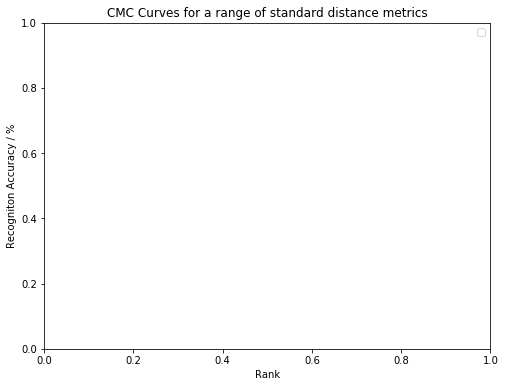

In [192]:
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold', 'lightgreen']
for i in range(len(metric_l)):
    plt.plot(np.arange(1, 31), 100*rank_accuracies_l[i], color=color_list[i], linestyle='dashed', label='k : '+str(metric_l[i]))

plt.title('CMC Curves for a range of standard distance metrics')
plt.xlabel('Rank')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')

In [ ]:

rank_accuracy_base = np.array([47.00, 54.57, 59.64, 63.93, 66.86, 69.29, 71.14, 72.36, 73.71, 74.93, 75.86, 76.79, 77.71, 78.50, 79.07, 79.86, 80.64, 81.57, 82.29, 83.21, 83.50, 83.71, 84.00, 84.29, 84.79, 85.29, 85.64, 85.93, 86.07, 86.36])




In [ ]:
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold', 'lightgreen']
for i in range(len(num_clusters_l)):
    plt.plot(np.arange(1, 31), 100*rank_accuracies_l[i], color=color_list[i], linestyle='dashed', label='k = '+str(num_clusters_l[i]))
plt.plot(np.arange(1, 31), rank_accuracy_base, color='darkorange', linestyle=':', label='kNN baseline')
plt.title('CMC Curves for a range of number of neigbours ($k$)')
plt.xlabel('Rank')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')